In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


E0000 00:00:1731096848.919850  303471 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731096848.926463  303471 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [4]:
import tensorflow as tf
import keras
import pandas as pd
import os
import keras_cv
import matplotlib.pyplot as plt

In [5]:
csv_file = 'ham10000_data/HAM10000_metadata.csv'
img_dir = 'ham10000_data/images'
file_ext = '.jpg'

df = pd.read_csv(csv_file)

image_paths = [
    os.path.join(img_dir, image_id + file_ext)
    for image_id in df['image_id']
]

print(f"Number of images: {len(image_paths)}")
print(f"First 5 image paths: {image_paths[:5]}")

classes = sorted(df['dx'].unique())
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = df['dx'].map(lambda x: classes.index(x)).values
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Class to Index Mapping: {class_to_idx}")
print(f"Labels: {labels}")

Number of images: 10015
First 5 image paths: ['ham10000_data/images/ISIC_0027419.jpg', 'ham10000_data/images/ISIC_0025030.jpg', 'ham10000_data/images/ISIC_0026769.jpg', 'ham10000_data/images/ISIC_0025661.jpg', 'ham10000_data/images/ISIC_0031633.jpg']
Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class to Index Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Labels: [2 2 2 ... 0 0 4]


In [6]:
def load_and_preprocess_image(image_id, label):
    # Load and preprocess the image
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # ResNet expects 224x224 images
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing for ResNet

    # One-hot encode the label
    label = tf.one_hot(label, depth=num_classes)

    return image, label


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

train_paths = []
train_labels = []
val_paths = []
val_labels = []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(image_paths, labels):
    train_paths = [image_paths[i] for i in train_index]
    train_labels = labels[train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = labels[val_index]

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

Training set size: 8012
Validation set size: 2003


I0000 00:00:1731096852.798773  303471 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11139 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0b:00.0, compute capability: 6.0
I0000 00:00:1731096852.799342  303471 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15253 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:13:00.0, compute capability: 6.0


In [8]:
batch_size = 32

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()

val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache()


In [9]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Compute class counts and class priors
class_counts = np.bincount(train_labels)
total_counts = np.sum(class_counts)
class_prior = class_counts / total_counts

# Clip class_prior to avoid log(0)
class_prior = np.clip(class_prior, 1e-7, 1.0)
output_bias = np.log(class_prior)

print(f"Class Counts: {class_counts}")
print(f"Class Prior: {class_prior}")
print(f"Output Bias: {output_bias}")

Class Counts: [ 262  411  879   92  890 5364  114]
Class Prior: [0.03270095 0.05129805 0.10971043 0.01148278 0.11108337 0.66949576
 0.01422866]
Output Bias: [-3.42035119 -2.97010248 -2.2099108  -4.46690712 -2.19747423 -0.40123045
 -4.25249725]


In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification.

    Parameters:
    - gamma: Focusing parameter that adjusts the rate at which easy examples are down-weighted.
    - alpha: Balancing factor to balance the importance of different classes.

    Returns:
    - A loss function that can be used with multi-class classification models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Compute the focal loss weights
        loss_weight = alpha * K.pow(1 - y_pred, gamma)

        # Apply focal loss weights
        loss = loss_weight * cross_entropy

        # Sum over the last axis (the class axis)
        return K.sum(loss, axis=-1)

    return focal_loss_fixed


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Conv2D, Multiply, Add, Concatenate, Activation


class CBAM(Layer):
    def __init__(self, reduction_ratio=8, kernel_size=7, use_bias=True):
        super(CBAM, self).__init__()
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size
        self.use_bias = use_bias

    def build(self, input_shape):
        self.channel_axis = -1
        self.channel = input_shape[self.channel_axis]

        self.shared_dense_one = Dense(self.channel // self.reduction_ratio,
                                      activation='relu',
                                      kernel_initializer='he_normal',
                                      use_bias=self.use_bias)
        self.shared_dense_two = Dense(self.channel,
                                      activation='sigmoid',
                                      kernel_initializer='he_normal',
                                      use_bias=self.use_bias)
        self.conv = Conv2D(1, kernel_size=self.kernel_size, padding='same', activation='sigmoid')

    def channel_attention(self, input_tensor):
        avg_pool = GlobalAveragePooling2D()(input_tensor)
        avg_pool = Reshape((1, 1, self.channel))(avg_pool)

        max_pool = GlobalMaxPooling2D()(input_tensor)
        max_pool = Reshape((1, 1, self.channel))(max_pool)

        avg_out = self.shared_dense_one(avg_pool)
        avg_out = self.shared_dense_two(avg_out)

        max_out = self.shared_dense_one(max_pool)
        max_out = self.shared_dense_two(max_out)

        combined = Add()([avg_out, max_out])
        scale = Activation('sigmoid')(combined)

        return Multiply()([input_tensor, scale])

    def spatial_attention(self, input_tensor):
        avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.conv(concat)
        return Multiply()([input_tensor, spatial_attention])

    def call(self, input_tensor):
        x = self.channel_attention(input_tensor)
        x = self.spatial_attention(x)

        return x

In [13]:
import tensorflow as tf
from tensorflow import keras


def build_resnet50_with_cbam(hp):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling=None
    )

    # Freeze all layers initially
    base_model.trainable = False

    # Unfreeze later layers based on a hyperparameter
    unfreeze_from = hp.Choice('unfreeze_from', values=[0, -10, -20, -50])
    if unfreeze_from is not None:
        for layer in base_model.layers[unfreeze_from:]:
            layer.trainable = True

    reduction_ratio = hp.Choice('reduction_ratio', values=[4, 8, 16, 32])
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    use_bias = hp.Choice('use_bias', values=[True, False])

    x = CBAM(reduction_ratio=reduction_ratio, kernel_size=kernel_size, use_bias=use_bias)(
        base_model.get_layer("conv2_block3_out").output
    )

    x = CBAM(reduction_ratio=reduction_ratio, kernel_size=kernel_size, use_bias=use_bias)(
        base_model.get_layer("conv3_block4_out").output
    )

    x = CBAM(reduction_ratio=reduction_ratio, kernel_size=kernel_size, use_bias=use_bias)(
        base_model.get_layer("conv4_block6_out").output
    )

    x = CBAM(reduction_ratio=reduction_ratio, kernel_size=kernel_size, use_bias=use_bias)(
        base_model.get_layer("conv5_block3_out").output
    )

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3, 0.5])
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    output_bias = np.log(np.ones((num_classes,)) / num_classes)
    outputs = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
        bias_initializer=tf.keras.initializers.Constant(output_bias),
        kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_regularization_output', values=[0.01, 0.001, 0.0001]))
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    weight_decay = hp.Choice('weight_decay', values=[1e-2, 1e-3, 1e-4])
    optimizer_choice = hp.Choice('optimizer', values=['adamw', 'sgd'])

    if optimizer_choice == 'adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    else:
        momentum = hp.Choice('momentum', values=[0.8, 0.9, 0.99])
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=hp.Choice('gamma', values=[0.5, 1.0, 2.0]), alpha=hp.Choice('alpha', values=[0.25, 0.5, 0.75])),
        metrics=[
            tf.keras.metrics.AUC(name='auc', multi_label=False),
            'accuracy'
        ]
    )

    return model

In [14]:
from sklearn.utils import class_weight
import numpy as np


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))

In [15]:
import keras_tuner as kt

from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)


# Create a tuner
tuner = kt.Hyperband(
    build_resnet50_with_cbam,
    objective='val_auc',
    max_epochs=50,
    factor=3,
    directory='cbam_block_residual_3',
    project_name='hyperparameter_tuning'
)

# Perform the search
tuner.search(
  train_dataset,
  validation_data=val_dataset,
  epochs=50,
  class_weight=class_weights_dict,
  callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)


Trial 88 Complete [00h 03m 09s]
val_auc: 0.5056255459785461

Best val_auc So Far: 0.9693164825439453
Total elapsed time: 04h 34m 59s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x77399dd4e800>


In [16]:
import numpy as np


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=12,
        min_delta=1e-4,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.1,
        patience=4,
        min_lr=1e-7,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='best_models/resnet50-cbam-residual.keras',
        monitor='val_auc',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=callbacks,
    class_weight=class_weights_dict,
)

Epoch 1/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step - accuracy: 0.4836 - auc_2: 0.7738 - loss: 0.3809 - val_accuracy: 0.6740 - val_auc_2: 0.9315 - val_loss: 0.1826 - learning_rate: 0.0010
Epoch 2/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6200 - auc_2: 0.9026 - loss: 0.2194 - val_accuracy: 0.6990 - val_auc_2: 0.9408 - val_loss: 0.1702 - learning_rate: 0.0010
Epoch 3/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6455 - auc_2: 0.9160 - loss: 0.1976 - val_accuracy: 0.7339 - val_auc_2: 0.9535 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 4/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.6615 - auc_2: 0.9246 - loss: 0.1798 - val_accuracy: 0.7294 - val_auc_2: 0.9529 - val_loss: 0.1540 - learning_rate: 0.0010
Epoch 5/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.6781 - auc_2: 0.9315 - loss: 0.1712 - val_accuracy: 0.7279 - val_auc_2: 0.9503 - val_loss: 0.1612 - learning_rate: 0.0010
Epoch 6/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 

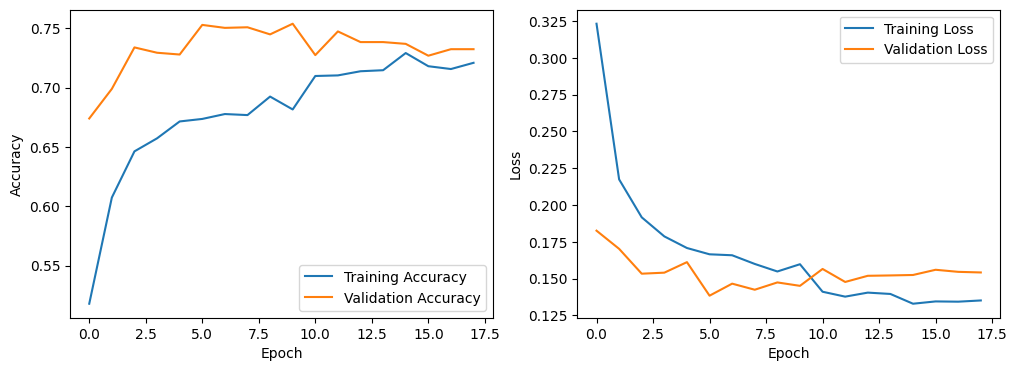

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []

def get_predictions(dataset):
    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Get predictions for validation dataset
y_true, y_pred = get_predictions(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

In [20]:
# Classification Report

y_true = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
y_pred = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       akiec       0.40      0.45      0.42        65
         bcc       0.47      0.69      0.56       103
         bkl       0.64      0.53      0.58       220
          df       0.14      0.65      0.23        23
         mel       0.54      0.43      0.47       223
          nv       0.90      0.87      0.89      1341
        vasc       0.69      0.71      0.70        28

    accuracy                           0.75      2003
   macro avg       0.54      0.62      0.55      2003
weighted avg       0.78      0.75      0.76      2003



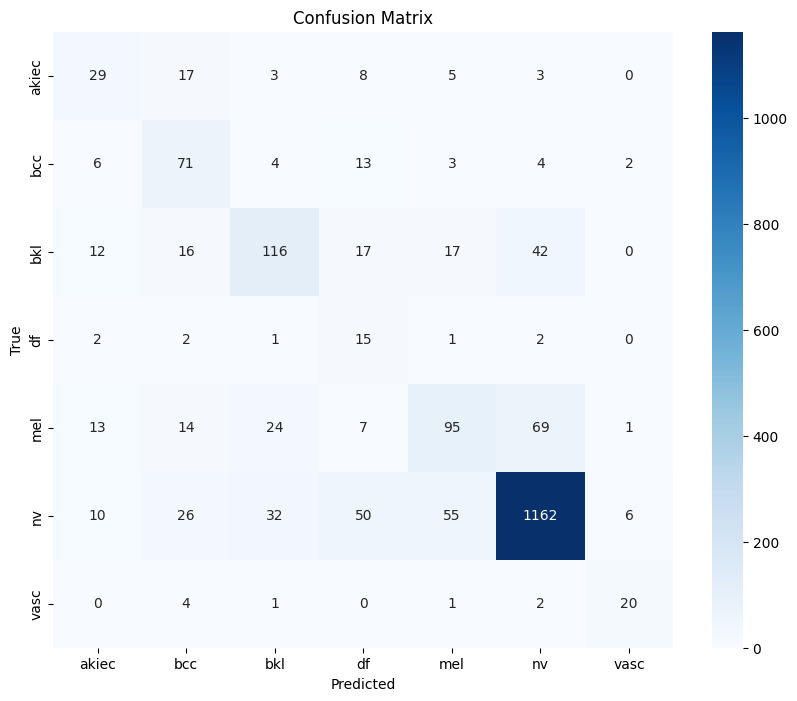

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

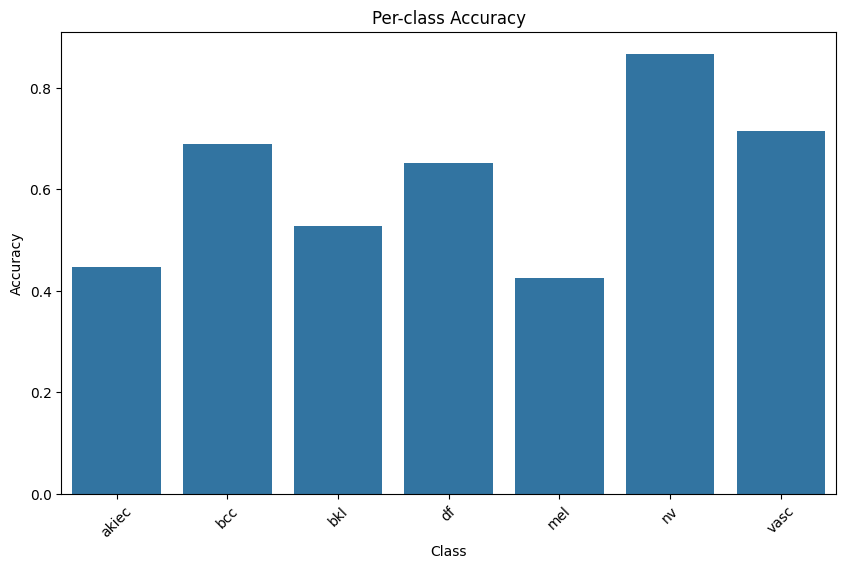

In [22]:
# Per-class Accuracy Plot
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_accuracies)
plt.title('Per-class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()